In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score
import cvxopt
from itertools import product

In [7]:
cvxopt.solvers.options['show_progress'] = False

def replace(data):
    d = {'N': -1, 'P': +1}
    return data.replace({"class": d})

def linear_kernel(x1, x2):
    return np.inner(x1, x2)

def polynomial_kernel(x1, x2, power, coef):
    return (np.inner(x1, x2) + coef) ** power

def radial_kernel(x1, x2, betha):
    distance = np.linalg.norm(x1 - x2) ** 2
    return np.exp(-betha * distance)

In [8]:
def lagranjian(a, x, y, ker):
    D = len(x)
    res = 0
    for i in range(D):
        res -= a[i]
        for j in range(D):
            res += 0.5 * a[i] * a[j] * y[i] * y[j] * ker(x[i], x[j])
    return res

In [ ]:
def derivative(a, x, y, ker):
    D = len(x)
    res = []
    for j in range(D):
        res[j] = 1 + (a[i] * y[i] * y[j] * ker(x[i], x[j]) for i in range(D))
    return res

In [ ]:
def make_b(a, x, y):
    w = 0
    B = list()
    for i in range(len(a)):
        if a[i] > 0:
            w += a[i] * y[i] * x[i]
    for i in range(len(a)):
        if a[i] > 0:
            B.append(w.dot(x[i]) - y[i])
    return median(B)

In [ ]:
def predict(a, x, X, y, kernel, b=None):
    res = 0
    if b is None:
        b = make_b(a, X, y)
    for i in range(len(X)):
        res += np.dot(a[i] * y[i], kernel(X[i], x)) - b
    return np.sign(res)

In [ ]:
def fit(X, y, kernel, C):
    x = [0 for i in range(len(X))]
    opt_res = minimize(lagranjian, x, (X, y, kernel), 'SLSQP', options={"maxiter": 2000}, bounds=Bounds(0.0, C), constraints=LinearConstraint(y, 0, 0), jac={derivative}) #, 
    if opt_res.success == False:
        print(opt_res.message)
    a = opt_res.x
    return a, make_b(a, X, y)

In [9]:
def draw_plot_contour(alfa, X, y, kernel, dataset_name):
    if dataset_name == 'chips':
        w1, w2 = np.mgrid[min(chips['x']): max(chips['x']):100j,
                    min(chips['y']): max(chips['y']):100j]
    else:
        w1, w2 = np.mgrid[min(geyser['x']): max(geyser['x']):100j,
                    min(geyser['y']): max(geyser['y']):100j]
    label = np.zeros((len(w1), len(w1)))
    for i in range(len(w1)):
        for j in range(len(list(zip(w1, w2))[i][0])):
            label[i][j] = predict(alfa, [list(zip(w1, w2))[i][0][j], list(zip(w1, w2))[i][1][j]], X, y, kernel)
    colors = ['red', 'blue']
    print(label)
    plt.contourf(w1, w2, label, colors=colors, alpha=0.2)
    plt.autoscale(False)
    if dataset_name == 'chips':
        plt.scatter(chips['x'], chips['y'], c=chips['class'], cmap=ListedColormap(colors), zorder=1)
    else:
        plt.scatter(geyser['x'], geyser['y'], c=geyser['class'], cmap=ListedColormap(colors), zorder=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Распределение классов в датасете {dataset_name}')
    plt.show()

In [10]:
def cross_validation_split(X, y, k_fold=5):
    Xs_train = []
    ys_train = []
    Xs_test = []
    ys_test = []
    n = len(X) // k_fold
    for i in range(k_fold):
        Xs_test.append(X[i * n: (i + 1) * n])
        Xs_train.append(np.concatenate((X[: i * n], X[(i + 1) * n:])))
        ys_test.append(y[i * n: (i + 1) * n])
        ys_train.append(np.concatenate((y[: i * n], y[(i + 1) * n:])))
    return Xs_train, Xs_test, ys_train, ys_test

chips = replace(pd.read_csv('chips.csv'))
chips['b'] = np.ones((len(chips), 1))
geyser = replace(pd.read_csv('geyser.csv'))
geyser['b'] = np.ones((len(geyser), 1))

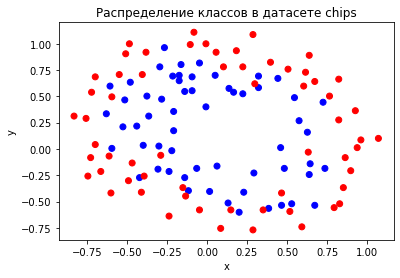

In [11]:
# Чипы

colors = ['red','blue']
plt.scatter(chips['x'], chips['y'], c=chips['class'], cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Распределение классов в датасете chips')
plt.show()

Chips, Линейное ядро, Лучшая точность: 0.5043478260869565, C: 0.05


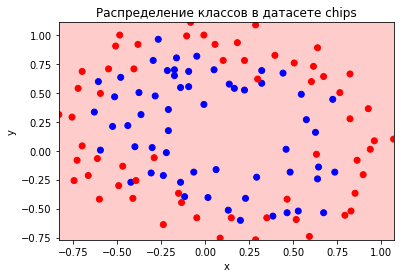

In [12]:
# Линейное ядро

X, y = geyser.values[:,:-1], geyser.values[:,-1]
#draw_plot(X, y)
C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
params = list(product(C))
accs = []
for param in params:
    acc_clf = []
    Xs_train, Xs_test, ys_train, ys_test = cross_validation_split(X, y)
    for i in range(len(Xs_train)):
        alfa, b = fit(Xs_train[i], ys_train[i], linear, param[0])
        y_pred = []
        for obj in Xs_test[i]:
            y_pred.append(predict(alfa, obj, Xs_test[i], ys_test[i], linear, b))
        acc_clf.append(accuracy_score(np.array(y_pred), ys_test[i]))
    accs.append(sum(acc_clf) / len(acc_clf))
print(f'Chips, Линейное ядро, Лучшая точность: {accs[accs.index(max(accs))]}, C: {params[accs.index(max(accs))][0]}')

alfa, b = fit(X, y, linear, params[accs.index(max(accs))][0])
draw_plot(alfa, X, y, linear, 'geyser')

Chips, Полиномиальное ядро, Лучшая точность: 0.826086956521739, C: 100.0, power: 2


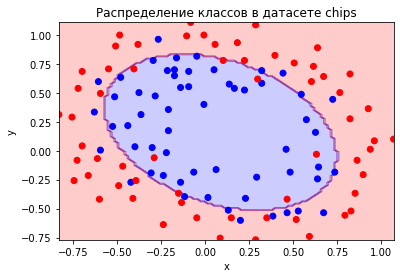

In [13]:
# Полиномиальное ядро

C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
powers = [2, 3, 4, 5]
params = list(product(C, powers))
accs = []
for param in params:
    acc_clf = []
    Xs_train, Xs_test, ys_train, ys_test = cross_validation_split(X, y)
    for i in range(len(Xs_train)):
        alfa, b = fit(Xs_train[i], ys_train[i], polynomial_kernel, C=param[0], power=param[1], coef=2)
        y_pred = predict(alfa, Xs_test[i], polynomial_kernel, b)
        acc_clf.append(accuracy_score(np.array(y_pred), ys_test[i]))
    accs.append(sum(acc_clf) / len(acc_clf))
print(f'Chips, Полиномиальное ядро, Лучшая точность: {accs[accs.index(max(accs))]}, C: {params[accs.index(max(accs))][0]}, power: {params[accs.index(max(accs))][1]}')

alfa, b = fit(X, y, polynomial_kernel, C=params[accs.index(max(accs))][0], power=params[accs.index(max(accs))][1], coef=1)
draw_plot(alfa, X, y, polynomial_kernel, 'chips')

Chips, Радиальное ядро, Лучшая точность: 0.7913043478260869, C: 10.0, betha: 1


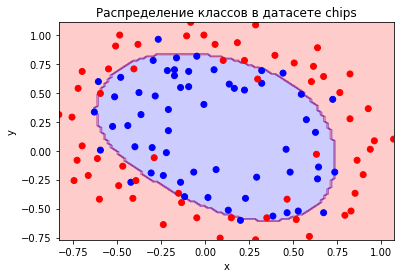

In [14]:
# Радиальное ядро

C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
bethas = [1, 2, 3, 4, 5]
params = list(product(C, bethas))
accs = []
for param in params:
    acc_clf = []
    Xs_train, Xs_test, ys_train, ys_test = cross_validation_split(X, y)
    for i in range(len(Xs_train)):
        alfa, b = fit(Xs_train[i], ys_train[i], radial_kernel, C=param[0], betha=param[1])
        y_pred = clf.predict(alfa, Xs_test[i], radial_kernel, b)
        acc_clf.append(accuracy_score(np.array(y_pred), ys_test[i]))
    accs.append(sum(acc_clf) / len(acc_clf))
print(f'Chips, Радиальное ядро, Лучшая точность: {accs[accs.index(max(accs))]}, C: {params[accs.index(max(accs))][0]}, betha: {params[accs.index(max(accs))][1]}')

alfa, b = fit(X, y, polynomial_kernel, C=params[accs.index(max(accs))][0], power=params[accs.index(max(accs))][1], coef=1)
draw_plot(alfa, X, y, polynomial_kernel, 'chips')

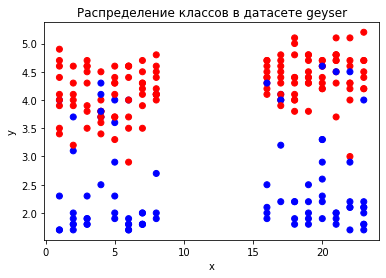

Geyser, Линейное ядро, Лучшая точность: 0.8454545454545455, C: 50.0


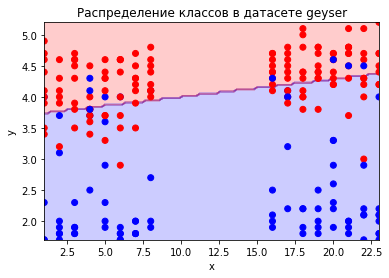

In [15]:
# Гейзеры

colors = ['red','blue']
plt.scatter(geyser[:,0], geyser[:,1], c=geyser[:,-1], cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Распределение классов в датасете geyser')
plt.show()

# Линейное ядро

X = geyser[:,:-1]
y = geyser[:,-1]
C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
params = list(product(C))
accs = []
for param in params:
    acc_clf = []
    Xs_train, Xs_test, ys_train, ys_test = cross_validation_split(X, y)
    for i in range(len(Xs_train)):
        alfa, b = fit(Xs_train[i], ys_train[i], kernel=linear_kernel, C=param[0])
        y_pred = predict(alfa, Xs_test[i], b)
        acc_clf.append(accuracy_score(np.array(y_pred), ys_test[i]))
    accs.append(sum(acc_clf) / len(acc_clf))
print(f'Geyser, Линейное ядро, Лучшая точность: {accs[accs.index(max(accs))]}, C: {params[accs.index(max(accs))][0]}')

alfa, b = fit(X, y, kernel=linear_kernel, C=params[accs.index(max(accs))][0])
draw_plot(alfa, X, y, kernel=linear_kernel, 'geyser')

Geyser, Полиномиальное ядро, Лучшая точность: 0.9045454545454545, C: 50.0, power: 2


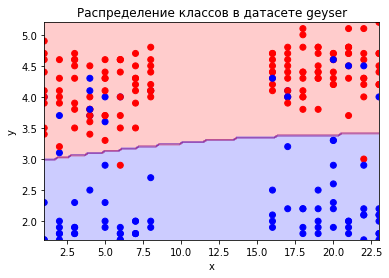

In [16]:
# Полиномиальное

C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
powers = [2, 3, 4, 5]
params = list(product(C, powers))
accs = []
for param in params:
    acc_clf = []
    Xs_train, Xs_test, ys_train, ys_test = cross_validation_split(X, y)
    for i in range(len(Xs_train)):
        alfa, b = fit(Xs_train[i], ys_train[i], kernel=polynomial_kernel, C=param[0], power=param[1], coef=2)
        y_pred = predict(alfa, Xs_test[i], b)
        acc_clf.append(accuracy_score(np.array(y_pred), ys_test[i]))
    accs.append(sum(acc_clf) / len(acc_clf))
print(f'Geyser, Полиномиальное ядро, Лучшая точность: {accs[accs.index(max(accs))]}, C: {params[accs.index(max(accs))][0]}, power: {params[accs.index(max(accs))][1]}')

alfa, b = fit(X, y, kernel=polynomial_kernel, C=params[accs.index(max(accs))][0], power=params[accs.index(max(accs))][1], coef=1)
draw_plot(alfa, X, y, polynomial_kernel, 'geyser')

Geyser, Радиальное ядро, Лучшая точность: 0.8363636363636363, C: 1.0, betha: 1


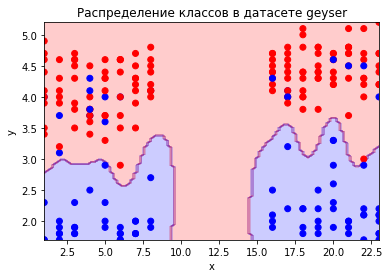

In [17]:
C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
bethas = [1, 2, 3, 4, 5]
params = list(product(C, bethas))
accs = []
for param in params:
    acc_clf = []
    Xs_train, Xs_test, ys_train, ys_test = cross_validation_split(X, y)
    for i in range(len(Xs_train)):
        alfa, b = fit(Xs_train[i], ys_train[i], C=param[0], betha=param[1])
        y_pred = clf.predict(alfa, Xs_test[i], b)
        acc_clf.append(accuracy_score(np.array(y_pred), ys_test[i]))
    accs.append(sum(acc_clf) / len(acc_clf))
print(f'Geyser, Радиальное ядро, Лучшая точность: {accs[accs.index(max(accs))]}, C: {params[accs.index(max(accs))][0]}, betha: {params[accs.index(max(accs))][1]}')

alfa, b = (X, y, radial_kernel, C=params[accs.index(max(accs))][0], betha=params[accs.index(max(accs))][1])
draw_plot(alfa, X, y, polynomial_kernel, 'geyser')
